In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os

DATA_DIR = '/content/drive/MyDrive/tomato disease 3'
print(os.listdir(DATA_DIR))

['Tomato_Spider_mites_Two_spotted_spider_mite']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


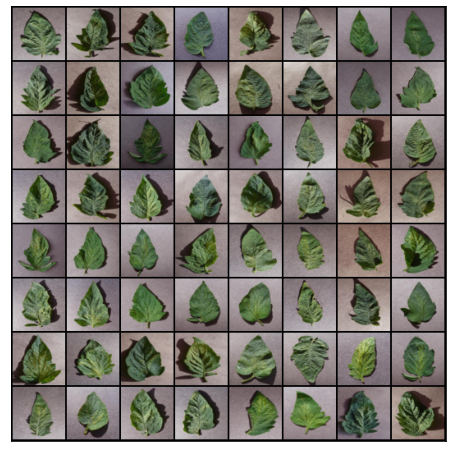

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([64, 3, 64, 64])


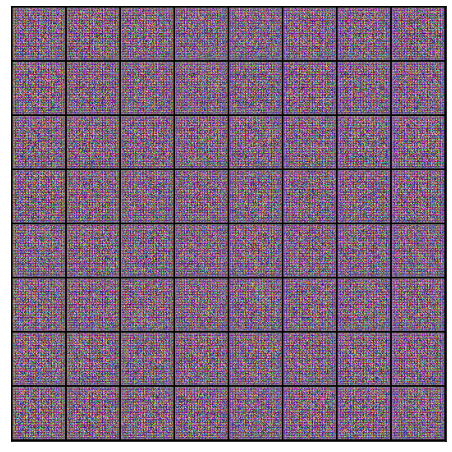

In [ ]:

xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image


In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


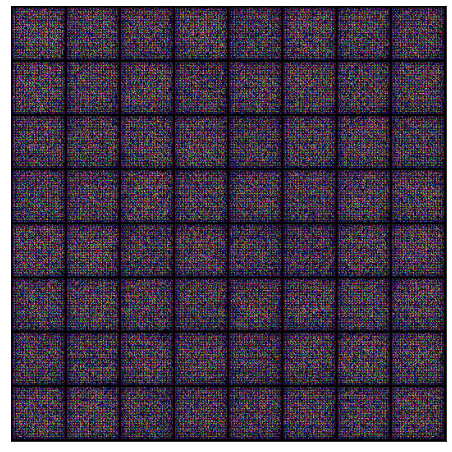

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.001
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/100], loss_g: 4.8758, loss_d: 1.9449, real_score: 0.2328, fake_score: 0.0039
Saving generated-images-0001.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 8.2327, loss_d: 0.0195, real_score: 0.9823, fake_score: 0.0011
Saving generated-images-0002.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 4.8286, loss_d: 0.4654, real_score: 0.9990, fake_score: 0.3196
Saving generated-images-0003.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 5.4164, loss_d: 0.0117, real_score: 0.9992, fake_score: 0.0108
Saving generated-images-0004.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 1.8407, loss_d: 1.6959, real_score: 0.3659, fake_score: 0.2486
Saving generated-images-0005.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 4.3293, loss_d: 0.5001, real_score: 0.8260, fake_score: 0.2327
Saving generated-images-0006.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 1.8928, loss_d: 0.8786, real_score: 0.7912, fake_score: 0.4008
Saving generated-images-0007.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.5887, loss_d: 0.6312, real_score: 0.6397, fake_score: 0.0780
Saving generated-images-0008.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.4023, loss_d: 2.5398, real_score: 0.1452, fake_score: 0.0041
Saving generated-images-0009.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.8679, loss_d: 0.3168, real_score: 0.7876, fake_score: 0.0511
Saving generated-images-0010.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.1739, loss_d: 0.4241, real_score: 0.7689, fake_score: 0.0807
Saving generated-images-0011.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 2.6243, loss_d: 0.8079, real_score: 0.6039, fake_score: 0.0571
Saving generated-images-0012.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 3.8654, loss_d: 0.4248, real_score: 0.9232, fake_score: 0.2580
Saving generated-images-0013.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.7746, loss_d: 0.2728, real_score: 0.8413, fake_score: 0.0149
Saving generated-images-0014.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.9322, loss_d: 0.1375, real_score: 0.8885, fake_score: 0.0105
Saving generated-images-0015.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 1.9739, loss_d: 0.4897, real_score: 0.6665, fake_score: 0.0129
Saving generated-images-0016.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 1.4352, loss_d: 0.5157, real_score: 0.7509, fake_score: 0.1223
Saving generated-images-0017.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 7.4876, loss_d: 0.5405, real_score: 0.9812, fake_score: 0.3565
Saving generated-images-0018.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.8655, loss_d: 0.1771, real_score: 0.8708, fake_score: 0.0111
Saving generated-images-0019.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.7330, loss_d: 0.9159, real_score: 0.9198, fake_score: 0.4990
Saving generated-images-0020.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 6.3562, loss_d: 0.6102, real_score: 0.8890, fake_score: 0.3451
Saving generated-images-0021.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 6.7156, loss_d: 0.4960, real_score: 0.9729, fake_score: 0.3432
Saving generated-images-0022.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.4555, loss_d: 0.2542, real_score: 0.8025, fake_score: 0.0150
Saving generated-images-0023.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 6.7646, loss_d: 0.7247, real_score: 0.9780, fake_score: 0.4640
Saving generated-images-0024.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.6055, loss_d: 0.0340, real_score: 0.9869, fake_score: 0.0201
Saving generated-images-0025.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 6.4297, loss_d: 0.7097, real_score: 0.9393, fake_score: 0.4327
Saving generated-images-0026.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 4.0459, loss_d: 0.1064, real_score: 0.9612, fake_score: 0.0628
Saving generated-images-0027.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 4.0731, loss_d: 0.1589, real_score: 0.9266, fake_score: 0.0429
Saving generated-images-0028.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.0759, loss_d: 1.7838, real_score: 0.2496, fake_score: 0.0470
Saving generated-images-0029.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.5803, loss_d: 0.0952, real_score: 0.9397, fake_score: 0.0307
Saving generated-images-0030.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 6.4800, loss_d: 0.7186, real_score: 0.9920, fake_score: 0.4699
Saving generated-images-0031.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.6565, loss_d: 0.5222, real_score: 0.8876, fake_score: 0.2830
Saving generated-images-0032.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 8.9110, loss_d: 0.8503, real_score: 0.9954, fake_score: 0.5124
Saving generated-images-0033.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 7.5815, loss_d: 0.8746, real_score: 0.9327, fake_score: 0.4889
Saving generated-images-0034.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.4229, loss_d: 0.1552, real_score: 0.9478, fake_score: 0.0857
Saving generated-images-0035.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.3054, loss_d: 0.1577, real_score: 0.9729, fake_score: 0.0932
Saving generated-images-0036.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 2.9846, loss_d: 0.4095, real_score: 0.9168, fake_score: 0.2425
Saving generated-images-0037.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.3955, loss_d: 0.1500, real_score: 0.9808, fake_score: 0.1154
Saving generated-images-0038.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 2.6188, loss_d: 2.7350, real_score: 0.1001, fake_score: 0.0014
Saving generated-images-0039.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.3855, loss_d: 0.3549, real_score: 0.7620, fake_score: 0.0530
Saving generated-images-0040.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 2.3408, loss_d: 2.4429, real_score: 0.1871, fake_score: 0.0112
Saving generated-images-0041.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.4042, loss_d: 0.3195, real_score: 0.8017, fake_score: 0.0654
Saving generated-images-0042.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.2486, loss_d: 0.2688, real_score: 0.8096, fake_score: 0.0433
Saving generated-images-0043.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 2.5185, loss_d: 0.6161, real_score: 0.5947, fake_score: 0.0500
Saving generated-images-0044.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 5.3520, loss_d: 0.8554, real_score: 0.9801, fake_score: 0.4292
Saving generated-images-0045.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 7.0097, loss_d: 0.7741, real_score: 0.9386, fake_score: 0.4425
Saving generated-images-0046.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 2.9467, loss_d: 0.3739, real_score: 0.9699, fake_score: 0.2618
Saving generated-images-0047.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 4.4397, loss_d: 0.7270, real_score: 0.5373, fake_score: 0.0145
Saving generated-images-0048.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.0118, loss_d: 0.5684, real_score: 0.8015, fake_score: 0.2580
Saving generated-images-0049.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 13.0129, loss_d: 1.4155, real_score: 0.9820, fake_score: 0.6568
Saving generated-images-0050.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.2224, loss_d: 1.0022, real_score: 0.4783, fake_score: 0.0108
Saving generated-images-0051.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.4433, loss_d: 0.2470, real_score: 0.8200, fake_score: 0.0352
Saving generated-images-0052.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.5595, loss_d: 0.0878, real_score: 0.9264, fake_score: 0.0087
Saving generated-images-0053.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 7.0009, loss_d: 0.8505, real_score: 0.9753, fake_score: 0.4423
Saving generated-images-0054.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 4.8006, loss_d: 0.2099, real_score: 0.9497, fake_score: 0.1372
Saving generated-images-0055.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 4.4377, loss_d: 0.1798, real_score: 0.8661, fake_score: 0.0086
Saving generated-images-0056.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 3.8422, loss_d: 0.0736, real_score: 0.9694, fake_score: 0.0399
Saving generated-images-0057.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 2.3055, loss_d: 2.8829, real_score: 0.1020, fake_score: 0.0002
Saving generated-images-0058.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 5.4064, loss_d: 0.2916, real_score: 0.9733, fake_score: 0.2133
Saving generated-images-0059.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.2498, loss_d: 0.5883, real_score: 0.6156, fake_score: 0.0201
Saving generated-images-0060.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 3.9084, loss_d: 0.3203, real_score: 0.7749, fake_score: 0.0174
Saving generated-images-0061.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 7.3479, loss_d: 0.4142, real_score: 0.9913, fake_score: 0.2812
Saving generated-images-0062.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 13.0328, loss_d: 1.4963, real_score: 0.9758, fake_score: 0.7061
Saving generated-images-0063.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 6.7799, loss_d: 0.5036, real_score: 0.9508, fake_score: 0.3176
Saving generated-images-0064.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 5.0119, loss_d: 0.8224, real_score: 0.5533, fake_score: 0.0061
Saving generated-images-0065.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 4.3429, loss_d: 0.0783, real_score: 0.9861, fake_score: 0.0599
Saving generated-images-0066.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 5.9867, loss_d: 0.3239, real_score: 0.9598, fake_score: 0.2247
Saving generated-images-0067.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 5.7298, loss_d: 0.1580, real_score: 0.9161, fake_score: 0.0590
Saving generated-images-0068.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 6.7218, loss_d: 0.2290, real_score: 0.9163, fake_score: 0.1197
Saving generated-images-0069.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 6.3108, loss_d: 0.2177, real_score: 0.8373, fake_score: 0.0129
Saving generated-images-0070.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 8.0900, loss_d: 0.1677, real_score: 0.9203, fake_score: 0.0726
Saving generated-images-0071.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.1368, loss_d: 0.1758, real_score: 0.9138, fake_score: 0.0697
Saving generated-images-0072.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 2.5129, loss_d: 0.4637, real_score: 0.6961, fake_score: 0.0346
Saving generated-images-0073.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 10.1755, loss_d: 0.7121, real_score: 0.9139, fake_score: 0.3970
Saving generated-images-0074.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.1373, loss_d: 0.2089, real_score: 0.9737, fake_score: 0.1529
Saving generated-images-0075.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 7.9962, loss_d: 0.3501, real_score: 0.9675, fake_score: 0.2414
Saving generated-images-0076.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 5.1514, loss_d: 0.2400, real_score: 0.8880, fake_score: 0.0988
Saving generated-images-0077.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.2906, loss_d: 1.3655, real_score: 0.3483, fake_score: 0.0003
Saving generated-images-0078.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.4656, loss_d: 0.2431, real_score: 0.9931, fake_score: 0.1751
Saving generated-images-0079.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 4.5034, loss_d: 0.3784, real_score: 0.8429, fake_score: 0.1478
Saving generated-images-0080.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.8325, loss_d: 0.2527, real_score: 0.8953, fake_score: 0.1174
Saving generated-images-0081.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 5.1994, loss_d: 0.2120, real_score: 0.9011, fake_score: 0.0847
Saving generated-images-0082.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 8.3965, loss_d: 1.4300, real_score: 0.4285, fake_score: 0.0004
Saving generated-images-0083.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 11.1273, loss_d: 1.0960, real_score: 0.9169, fake_score: 0.5703
Saving generated-images-0084.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 7.1274, loss_d: 0.4323, real_score: 0.9238, fake_score: 0.2437
Saving generated-images-0085.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.1953, loss_d: 0.2758, real_score: 0.8802, fake_score: 0.1208
Saving generated-images-0086.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 5.5671, loss_d: 0.1759, real_score: 0.9682, fake_score: 0.1246
Saving generated-images-0087.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 5.1434, loss_d: 0.6003, real_score: 0.6099, fake_score: 0.0004
Saving generated-images-0088.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.5187, loss_d: 0.5014, real_score: 0.7295, fake_score: 0.1068
Saving generated-images-0089.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 5.8656, loss_d: 1.2415, real_score: 0.4186, fake_score: 0.0008
Saving generated-images-0090.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.4187, loss_d: 1.0611, real_score: 0.5343, fake_score: 0.0204
Saving generated-images-0091.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.5874, loss_d: 0.1533, real_score: 0.9322, fake_score: 0.0740
Saving generated-images-0092.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 1.9339, loss_d: 0.3548, real_score: 0.7790, fake_score: 0.0558
Saving generated-images-0093.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 1.5239, loss_d: 0.8151, real_score: 0.5773, fake_score: 0.0242
Saving generated-images-0094.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 5.6664, loss_d: 0.1663, real_score: 0.8807, fake_score: 0.0163
Saving generated-images-0095.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 5.0125, loss_d: 0.2414, real_score: 0.8760, fake_score: 0.0869
Saving generated-images-0096.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 5.6164, loss_d: 0.1879, real_score: 0.9354, fake_score: 0.1041
Saving generated-images-0097.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 7.1303, loss_d: 0.1816, real_score: 0.9969, fake_score: 0.1425
Saving generated-images-0098.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 3.4506, loss_d: 2.2424, real_score: 0.1841, fake_score: 0.0001
Saving generated-images-0099.png


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 10.9892, loss_d: 1.3938, real_score: 0.9956, fake_score: 0.6100
Saving generated-images-0100.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

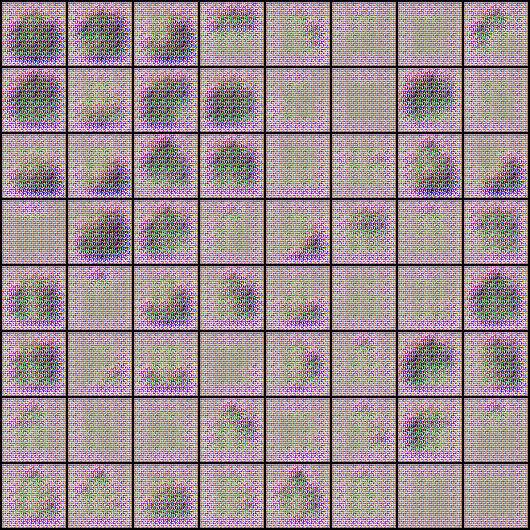

In [ ]:
Image('./generated/generated-images-0001.png')

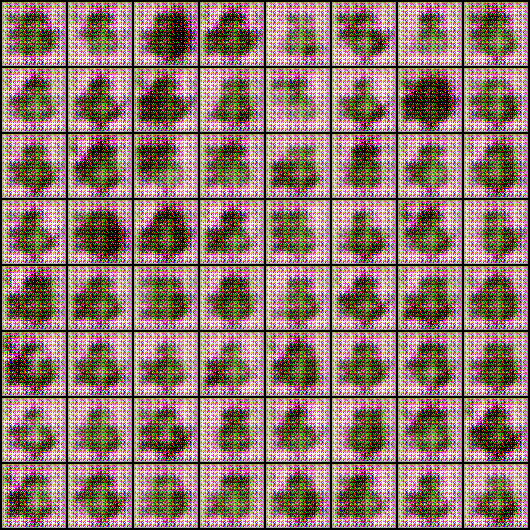

In [ ]:
Image('./generated/generated-images-0005.png')

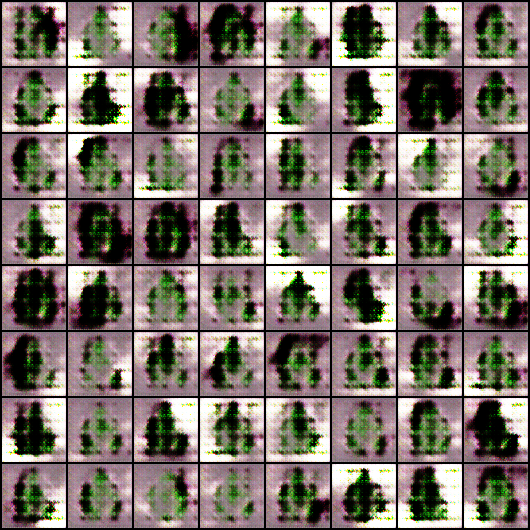

In [ ]:
Image('./generated/generated-images-0010.png')

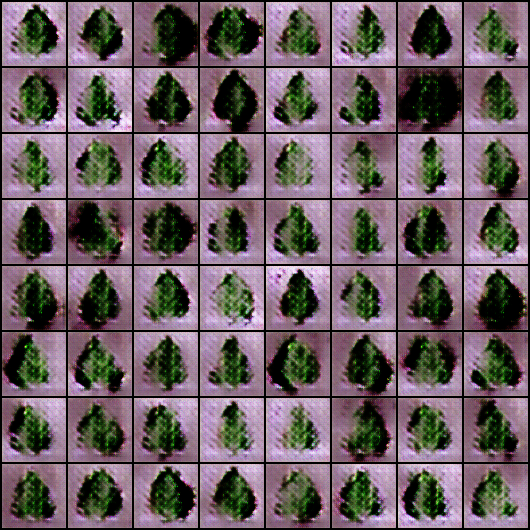

In [ ]:
Image('./generated/generated-images-0020.png')

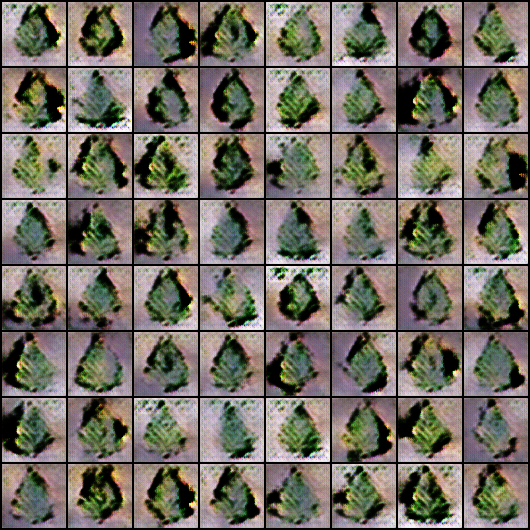

In [ ]:
Image('./generated/generated-images-0025.png')

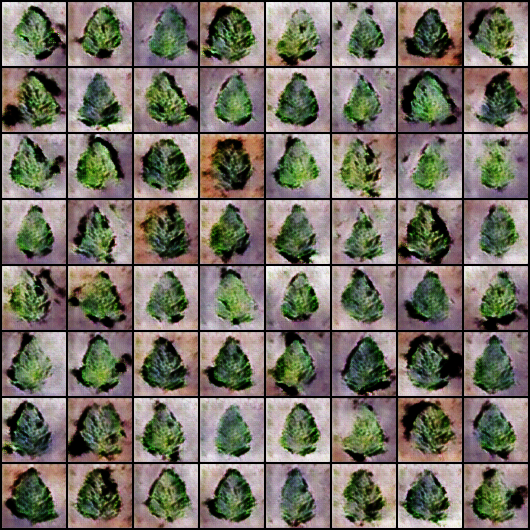

In [ ]:
Image('./generated/generated-images-0050.png')

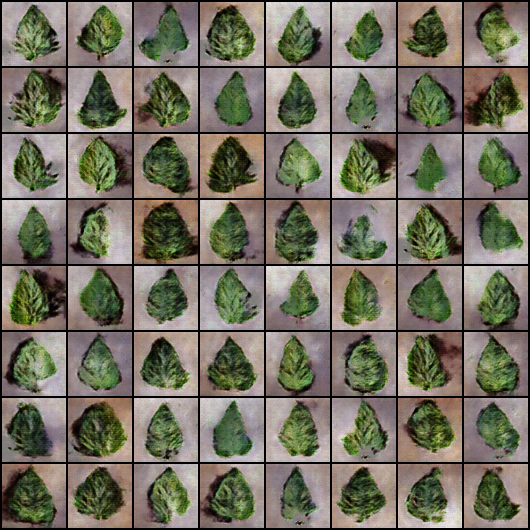

In [ ]:
Image('./generated/generated-images-0100.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

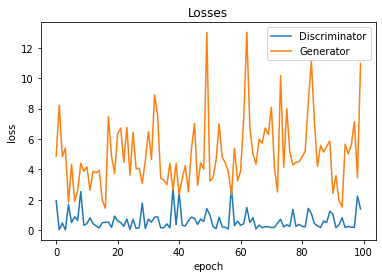

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

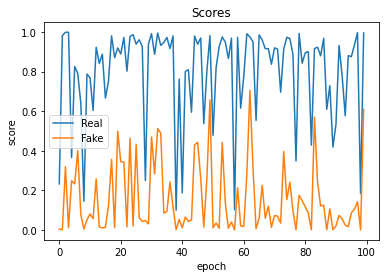

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import cv2
vidcap = cv2.VideoCapture('gans_training.avi')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [ ]:
!pip install image_slicer

In [ ]:
import io
import zipfile
import image_slicer
tiles = image_slicer.slice('./generated/generated-images-0100.png', 64, save=False)
with zipfile.ZipFile('Tomato_Spider_mites_Two_spotted_spider_mite.zip', 'w') as zip:
    for tile in tiles:
        with io.BytesIO() as data:
             tile.save(data)
             zip.writestr(tile.generate_filename(path=False),
                         data.getvalue())